# Requirements to run

We recommend generatating a new Anaconda environment before trying to run this project.
The reason is that igraph may have dependencies that conflict with your other project configurations.
As a consequence a new Anaconda environment will likely lead to less debugging and conflicting package issues.

### If you miss a dependency
conda install -c conda-forge python-igraph <br/>
conda install -c conda-forge pycairo <br/>
conda install pandas

Note that the correct igraph package is listed at https://igraph.org/python/doc/tutorial/install.html and NOT at anaconda.org!

In [12]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import igraph as igraph
import math
import numpy as np
import os as os
import csv
import random

### Check igraph installation 
This is purely for ensuring the package has been installed correctly

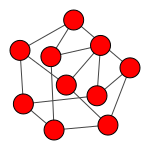

In [2]:
import igraph as ig
g = ig.Graph.Famous("petersen")
ig.plot(g, bbox=(0, 0, 150, 150))

# Notes on JSONs
33395: complexity outcome is more complicated due to text-icon split than with list item clickables due to how the interface has been defined. In reality there should be no complexity difference for the user. No action taken as of now. For this issue <br/>

### Component mappings
|Component | Code | Operation |
--- | --- | ---|
|Background Image| BI | Tap |
|Button Bar| BB| Tap|
|Checkbox | C | Tap |
|Card | CC | Tap |
|Icon | I| Tap |
|Input | IP | Input |
|Map View | MV | Multi |
| | | |


In [3]:
#give filename as "id.json"
#1809.json
#546.json

verticesMap = {"Advertisement": "AD",
               "Background Image": "BI",
               "Button Bar": "BB", 
               "Checkbox": "C", 
               "Card": "CC",
               "Date Picker": "DP",
               "Icon": "I", 
               "Image": "IM", 
               "Input": "IP", 
               "List Item": "L", 
               "Map View": "M",
               "On/Off Switch": "S",
               "Pager Indicator": "P",
               "Radio Button": "RB", 
               "Text": "TC", 
               "Text Button": "TB", 
               "Web View": "WV"}

edgesMap = {"AD": "Tap",
            "BB": "Tap",
            "BI": "Tap",
            "C": "Tap", 
            "CC": "Tap",
            "DP": "Multi",
            "I": "Tap", 
            "IM": "Tap", 
            "IP": "Input", 
            "L": "Tap", 
            "M": "Multi",
            "P": "Swipe",
            "RB": "Tap", 
            "S": "Tap",
            "TB": "Tap", 
            "TC": "Tap", 
            "WV": "Tap"} 

doNotEndTask = ["Checkbox", "Date Picker", "Input", "On/Off Switch"]

## Extract components from file

In [4]:
def getNormalizedBounds(dimensions, bounds):
    x1 = bounds[0] / dimensions[2]
    y1 = bounds[1] / dimensions[3]
    x2 = bounds[2] / dimensions[2]
    y2 = bounds[3] / dimensions[3]
    return [x1, y1, x2, y2]

def sortControlComponents(components):
    sortedComponents = []
    for component in components:
        bounds = component[1]
        componentPosition = 0
        for i in range(len(sortedComponents)):
            compareTo = sortedComponents[i]
            compareToBounds = compareTo[1]
            #If the new component is below the previous one then we move 
            #it to towards the end of component ordering
            if bounds[1] > compareToBounds[3]:
                componentPosition += 1
            #if we have overlap between the components we choose by
            #the component ordering in horizontal plane
            elif bounds[0] > compareToBounds[2]:
                componentPosition += 1
            #otherwise we assume that the current component is before the other component
        sortedComponents.insert(componentPosition, component)
    return sortedComponents
        

def getControlComponents(children):
    controlComponents = []
    def loopForControlComponents(children):
        for c in children:
            clickable = c['clickable']
            if(clickable):
                controlComponents.append((clickable, c['bounds'], 
                                          c['componentLabel']))
            elif("children" in c):
                loopForControlComponents(c["children"])
                
    loopForControlComponents(children)
    ccCount = len(controlComponents)
    return controlComponents, ccCount

## Define Matrix Structure
The matrix is defined as such that any connection flowing downwards from a node above is marked in the matrix row that defines the node existing underneat it with a value 1. In other words if the first node flows to the leftmost node below it from the left we have a matrix:<br/>
[[0,0,0],<br/>
 [1,0,0],<br/>
 [0,0,0]]<br/>
 In the above definition one node is not connected to anything.
 If node on second level had a connection to two other nodes underneath it we would define the matrix as:<br/>
 [[0,0,0,0],<br/>
  [1,0,0,0],<br/>
  [0,1,0,0],<br/>
  [0,1,0,0]]<br/>

In [5]:
def defineAdjacencyMatrix(controlComponents, ccCount): 
    adjacencyMatrix =  [[0] * (ccCount+2)]
    endVector = [0] * (ccCount+2) 
    endpointsCounter = ccCount
    #this defines where the next nodes shall form connections
    currentAnchorColumn = 0
    componentLimit = ccCount - 1
    for i in range(ccCount): 
            component = controlComponents[i]
            intermediateVector = []
            
            #special case for filling a login code with automatic UI refresh 
            #when Input field meets required length
            if(component[2] in doNotEndTask and i == componentLimit):
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            elif(component[2] in doNotEndTask):
                intermediateVector = [0] * (ccCount+1) 
                intermediateVector.insert(currentAnchorColumn, 1) 
                currentAnchorColumn = i + 1
                endVector[i+1] = 0
                endpointsCounter -= 1
            else:
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            adjacencyMatrix = adjacencyMatrix + [intermediateVector] 
            #endVector[id+1] = 1
    adjacencyMatrix = adjacencyMatrix + [endVector] 
    print("adjacencymatrix")
    for a in adjacencyMatrix:
        print(a)
    return np.array(adjacencyMatrix), endpointsCounter


def defineVertices(adjacencyMatrix, controlComponents): 
    verticeLabels = ["E"] 
    
    noEndpoints = pd.DataFrame(adjacencyMatrix)
    noEndpoints.drop(0,inplace=True)
    noEndpoints.drop(noEndpoints.tail(1).index,inplace=True)
    print("No endpoints")
    print(noEndpoints)
    layersWithVertices = noEndpoints.sum(axis=0) 
    print("WITH Vertices sum")
    print(layersWithVertices)
    layersWithVertices = layersWithVertices[layersWithVertices != 0]
    print("Some operation not equals zero")
    print(layersWithVertices)
    columnsWithVerticesIndexes = layersWithVertices.index
    print("Extract column pos")
    print(columnsWithVerticesIndexes)
    currentComponentItem = 0
    for i in columnsWithVerticesIndexes:
        currentColumn = adjacencyMatrix[:, i]
        for row, c in enumerate(currentColumn):
            if c == 1:
                currentItem = controlComponents[currentComponentItem][2]
                #These form the base level of the graph and other components are inserted around these
                #to match the order required by igraph
                if(i == 0):
                    verticeLabels.append(verticesMap[currentItem])
                else:
                    verticeLabels.insert(row-1, verticesMap[currentItem])
                currentComponentItem += 1

    #verticesPerLayer= layersWithVertices.iloc[layersWithVertices.to_numpy().nonzero()[0]].to_numpy()
    #for c in controlComponents: 
    #    if(c[2] in verticesMap): 
    #        print("c", c[2], "v", verticesMap[c[2]])
    #        verticeLabels = verticeLabels + [verticesMap[c[2]]]
    #verticeLabels = ["E"] + verticeLabels 
    verticeLabels = verticeLabels + ["S"] 
    return verticeLabels 

def defineEdges(adjacencyMatrix, verticeLabels, endpointCount):
    edgeLabels = []

    #edgesPerLayer.loc[:, (edgesPerLayer != 0).any(axis=0)]
    #print("--")
    #print(noEndpoints)
    #print("--")
    #print(edgesPerLayer)
    
    #currentEdgeGroup = 0
    workedThroughGroupItems = 0
    for v in range(len(verticeLabels)-1):
        if(verticeLabels[v] in edgesMap):
            
            edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
            #currentEdge = 0
        elif(verticeLabels[v] == "E"):
            edgeLabels = (["O"]*endpointCount) + edgeLabels
    #for v in range(len(verticeLabels)-1,-1,-1):
    #    print("V is", v, verticeLabels[v])
    #    if(verticeLabels[v] in edgesMap):
    #        edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
    #    elif(verticeLabels[v] == "E"):
    #        edgeLabels = (["O"]*endpointCount) + edgeLabels
    return edgeLabels

## Complexity Computations

In [6]:
def computeHalstead(edgeLabels, verticeLabels):
    #number of unique operators
    n1 = len(set(edgeLabels))
    #number of unique operands. We remove start and end
    n2 = len(set(verticeLabels))-2
    #total frequency of operators
    N1 = len(edgeLabels)
    #total frequency of operands. We remote start and end 
    N2 = len(verticeLabels)-2
    
    firstPart = (n1*N2*(N1+N2))/(2*n2)
    logPart = math.log(n1+n2, 2)
    #rounded to S significant numbers
    return round(firstPart*logPart,3)

#we have omitted McCabe from this work due to difficulties with scaling
#McCabe might be a suitable measure in other contexts
def computeMcCabeVG(adjacencyMatrix):
    nodes = len(adjacencyMatrix)
    #vertices = 0
    edges = adjacencyMatrix.sum().sum()
   # for a in adjacencyMatrix:
    #    print(a)
    #    vertices += a.count(1)
    return nodes - edges

#This is the Shannon Entropy based ID measure
def indexOfDifficulty(startPosition, targetComponent):
    W = 0
    
    startX = (startPosition[2] - startPosition[0])/2 + startPosition[0]
    startY = (startPosition[3] - startPosition[1])/2 + startPosition[1]
    targetWidth = targetComponent[2] - targetComponent[0]
    targetHeight = targetComponent[3] - targetComponent[1]
    targetXCenter = targetWidth / 2 + targetComponent[0]
    targetYCenter = targetHeight / 2 + targetComponent[1]
    
    if(targetWidth < targetHeight):
        W = targetWidth
    else:
        W = targetHeight
    A = math.sqrt(math.pow(targetXCenter - startX, 2) + math.pow(targetYCenter - startY, 2))
    ID = math.log(A/W+1,2)
    return ID

#called from computeWoodEntropy()
def woodCoordinativeComplexity(adjacencyMatrix, sortedControlComponents, screenDimensions):
    difficultySum = 0
    for i in range(len(sortedControlComponents)):
        currentAdjacencyRow = adjacencyMatrix[i+1]
        startComponentIndex = np.where(currentAdjacencyRow==1)[0][0]
        startComponent = []
        if(startComponentIndex == 0):
            startComponent = screenDimensions
        else:
            startComponent = sortedControlComponents[startComponentIndex-1][1]
            
        difficultySum += indexOfDifficulty(startComponent, sortedControlComponents[i][1])
    return round(difficultySum, 2)

#This is a HCI modified version making use of Hick-Hyman law
def woodComponentComplexity(verticeLabels):
    print("VERTICE LABELS", verticeLabels)
    verticesCount = len(verticeLabels)
    return round(math.log(verticesCount, 2), 2)
    
    

def computeWoodEntropy(adjacencyMatrix, sortedControlComponents, screenDimensions, verticeLabels):
    #print("type", type(adjacencyMatrix))
    coordinativeComplexity = woodCoordinativeComplexity(adjacencyMatrix, sortedControlComponents, screenDimensions)
    componentComplexity = woodComponentComplexity(verticeLabels)
    
    return coordinativeComplexity, componentComplexity

## Call function and visualization

In [7]:
def getFile(fileName):
    with open("hierarchies/"+fileName, encoding="utf-8") as f:
        data = json.load(f)
        dimensions = data['bounds']
        children = data['children']
        return dimensions, children

def visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, manualTest=False):
    directed = ig.Graph.Adjacency(adjacencyMatrix, mode="directed") 
    directed.vs["label"] = verticeLabels
    directed.vs["color"] = "white"
    directed.es["label"] = edgeLabels
    #directed.es["curved"] = seq(-0.5, 0.5, length = ecount(directed))
    directed.es["curved"] = False
    layout = directed.layout("rt")
    #save to file
    #return as a plot for a jupyter cell
    if(manualTest == True):
        return ig.plot(directed,  layout=layout, bbox=(0, 0, 350, 350), margin=20)
    
    ig.plot(directed, "graphs/"+fileName[:-5]+".png", layout=layout, bbox=(0, 0, 800, 800), margin=20)
    return
 

def determineControlGraphForFile(file):
    screenDimensions, children = getFile(file)
    print("DIMENSIONS", screenDimensions)
    controlComponents, ccCount = getControlComponents(children)
    #we need to sort control components as they are not always
    #in a sensible order from the perspective of how the actions would be performed
    sortedControlComponents = sortControlComponents(controlComponents)
    adjacencyMatrix, endpointCount = defineAdjacencyMatrix(sortedControlComponents, ccCount)
    verticeLabels = defineVertices(adjacencyMatrix, sortedControlComponents)
    edgeLabels = defineEdges(adjacencyMatrix, verticeLabels, endpointCount)

    #complexity computation
    halstead = computeHalstead(edgeLabels, verticeLabels)
    mcCabe = computeMcCabeVG(adjacencyMatrix)
    woodCoordinative, woodComponent = computeWoodEntropy(
        adjacencyMatrix, sortedControlComponents, screenDimensions, verticeLabels)
    
    print("Halstead", halstead, "McCabe", mcCabe, "Wood coordinative", woodCoordinative, 
          "Wood component", woodComponent, "Wood total", round(woodCoordinative+woodComponent,2))
    return [file, adjacencyMatrix, verticeLabels, edgeLabels, halstead,woodCoordinative, woodComponent, mcCabe]

## Generate graphs for all json files

In [8]:
def listAllFiles(folderPath):
    return os.listdir(folderPath)

def writeAnalyticsDataToFile(graphArrays):
    header = ['id', 'halstead', 'coordinative', 'component', 'wood', 'mccabe', 'paths', 'components']
    with open('./analytics.csv', 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for graphArray in graphArrays:
            paths = 0
            for row in graphArray[1]:
                if row[0] == 1:
                    paths +=1
            #file = graphArray[0]
            print("control graph--", graphArray[1])
            rowToWrite = [graphArray[0], graphArray[4], graphArray[5], graphArray[6], 
                          round(graphArray[5]+graphArray[6], 2), graphArray[7], paths, len(graphArray[2])-2]
            writer.writerow(rowToWrite)
        
def writeErrorsDataToFile(errors):
    with open('.errors.csv', 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(['file', 'error'])
        writer.writerows(errors)
    

def loopAllJsonFiles(folderPath):
    allFiles = listAllFiles(folderPath)
    csvAnalytics = []
    errors = []
    for f in allFiles:
        try:
            print("Starting file", f)
            print("------------")

            controlGraphArray = determineControlGraphForFile(f)
            csvAnalytics.append(controlGraphArray)
            visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], f)
        except  Exception as e:
            errors.append([f, e])
            continue
    writeAnalyticsDataToFile(csvAnalytics)
    writeErrorsDataToFile(errors)

In [11]:
loopAllJsonFiles("hierarchies")

Starting file 10128.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 5.99 Wood component 2.0 Wood total 7.99
Starting file 10180.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract col

Starting file 10594.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'M', 'TB', 'S']
Halstead 20.897 McCabe 0 Wood coordinative 2.95 Wood component 2.0 Wood total 4.95
Starting file 10596.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0,

Starting file 10743.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 5.17 Wood component 2.0 Wood total 7.17
Starting file 10798.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0,

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'CC', 'I', 'CC', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 6.28 Wood component 2.32 Wood total 8.6
Starting file 1130.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1

No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'IM', 'I', 'TB', 'S']
Halstead 37.151 McCabe -2 Wood coordinative 11.76 Wood component 2.58 Wood total 14.34
Starting file 11751.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.9 Wood component 1.58 Wood total 4.48
Starting file 11794.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[1,

0    10
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'TB', 'L', 'TB', 'S']
Halstead 300.0 McCabe -8 Wood coordinative 18.02 Wood component 3.58 Wood total 21.6
Starting file 12504.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'TB', 'S']
Halstead 48.0 McCabe -2 Wood coordinative 11.73 Wood component 2.58 Wood total 14.31
Starting file 12954.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    

Starting file 13648.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'L', 'L', 'L', 'L', 'L', 'L', 'S']
Halstead 147.0 McCabe -5 Wood coordinative 8.63 Wood component 3.17 Wood total 11.8
Starting file 13696.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencyma

Starting file 14143.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 7.45 Wood component 2.32 Wood total 9.77
Starting file 14247.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64

Starting file 14952.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.85 Wood component 1.58 Wood total 4.43
Starting file 14987.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.9 Wood component 1.58 Wood total 4.48
Starting file 15449.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extrac

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'CC', 'CC', 'CC', 'I', 'S']
Halstead 75.0 McCabe -3 Wood coordinative 10.46 Wood component 2.81 Wood total 13.27
Starting file 1611.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TC', 'TC', 'TC', 'TC', 'TB', 'S']
Halstead 83.589 McCabe -4 Wood coordinative 10.38 Wood component 3.0 Wood total 13.38
Starting file 16566.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'S']
Halstead 12.0 McCabe 0 Wood coordinative 6.03 Wood component 2.0 Wood total 8.03
Starting file 16946.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'S']
Halstead 12.0 McCabe 0 Wood coordinative 6.03 Wood component 2.0 Wood total 8.03
Starting file 17018.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 

------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 1.93 Wood component 1.58 Wood total 3.51
Starting file 18254.json
------------
DIMENSIONS [36, 447, 1403, 2029]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.49 Wood component 1.58 Wood total 4.07
Starting file 18262.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'I', 'TB', 'CC', 'S']
Halstead 83.589 McCabe -4 Wood coordinative 15.69 Wood component 3.0 Wood total 18.69
Starting file 18817.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 6.73 Wood component 2.32 Wood total 9.05
Starting file 19141.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  0  0  1  0  0  0  0
4  0  0  0  1  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    3
1    0
2    1
3    1
4    0
5    0
6    0
dtype: int64
Some operation not equals ze

Starting file 19730.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'I', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 147.0 McCabe -5 Wood coordinative 19.5 Wood component 3.17 Wood total 22.67
Starting file 19758.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjac

4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'S']
Halstead 48.0 McCabe -2 Wood coordinative 9.63 Wood component 2.58 Wood total 12.21
Starting file 20233.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 76.078 McCabe -2 Wood coordinative 5.33 Wood component 2.58 Wood total 7.91
Starting file 20234.json
------------
DIMENSIONS [0, 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   0   0   0   0   0
4    0   0   0   1   0   0   0   0   0   0   0   0
5    0   0   0   0   1   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    0   0   0   0   0   0   0   1   0   0   0   0
9    0   0   0   0   0   0   0   0   1

Starting file 21120.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 8.43 Wood component 2.32 Wood total 10.75
Starting file 21172.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0

13   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     12
1      0
2      0
3      0
4      0
5      1
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
dtype: int64
Some operation not equals zero
0    12
5     1
dtype: int64
Extract column pos
Int64Index([0, 5], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'IM', 'L', 'IP', 'TB', 'TB', 'WV', 'L', 'L', 'L', 'L', 'S']
Halstead 391.486 McCabe -10 Wood coordinative 27.93 Wood component 3.91 Wood total 31.84
Starting file 2128.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'S']
Halstead 27.0 McCab

Starting file 21777.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'IM', 'I', 'TB', 'CC', 'CC', 'CC', 'S']
Halstead 124.078 McCabe -6 Wood 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'IM', 'I', 'IM', 'IM', 'IM', 'S']
Halstead 192.0 McCabe -6 Wood coordinative 22.29 Wood component 3.32 Wo

   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'L', 'TB', 'L', 'TB', 'L', 'L', 'TB', 'S']
Halstead 147.0 McCabe -5 Wood coordinative 16.49 Wood component 3.17 Wood total 19.66
Starting file 22751.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'WV', 'S']
Halstead 37.151 McCabe -2 Wood coordinative 10.41 Wood component 2.58 Wood total 12.99
Starting file 23266.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[

Starting file 23823.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'IM', 'I', 'TB', 'TB', 'WV', 'I', 'S']
Halstead 94.997 McCabe -5 Wood coordinative 19.36 Wood component 3.17 Wood total 22.53
Starting file 23853.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adja

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'WV', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 6.67 Wood component 2.32 Wood total 8.99
Starting file 24579.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 8.83 Wood component 2.32 Wood total 11.15
Starting file 24777.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 

Starting file 25022.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  0  0  1  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    1
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    4
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'IP', 'I', 'TB', 'S']
Halstead 90.474 McCabe -2 Wood coordinative 9.38 Wood component 2.81 Wood total 12.19
Starting file 25035.json
------------
DIMENSIONS [160, 517, 1280, 1958]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0,

Starting file 26007.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'TB', 'WV', 'TB', 'TB', 'TB', 'S']
Halstead 83.589 McCabe -4 Wood coordinative 15.8 Wood component 3.0 Wood total 18.8
Starting file 26076.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   0   0   0   0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'IP', 'S']
Halstead 31.02 McCabe 0 Wood coordinative 5.62 Wood component 2.32 Wood total 7.94
Starting file 27664.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.9 Wood component 1.58 Wood total 4.48
Starting file 27717.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacen

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 6.42 Wood component 2.0 Wood total 8.42
Starting file 27920.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0


Starting file 28164.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TC', 'TB', 'TB', 'TC', 'TB', 'TC', 'TC', 'TB', 'S']
Halstead 192.0 McCabe -6 Wood

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'IM', 'WV', 'S']
Halstead 20.897 McCabe -1 Wood coordinative 9.13 Wood component 2.32 Wood total 11.45
Starting file 28535.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'IP', 'S']
Halstead 47.019 McCabe -1 Wood coordinative

No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'IM', 'L', 'I', 'I', 'I', 'S']
Halstead 148.603 McCabe -6 Wood coordinative 22.18 Wood component 3.32 Wood total 25.5
Starting file 29273.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  0  0  1  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    3
1    0
2    1
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    3
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'IP', 'TB', 'S']
Halstead 76.624 McCabe -1 Wood coordinative 7.43 Wood component 2.58 Wood total 10.01
Starting file 29704.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0

WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'TB', 'TB', 'TB', 'I', 'TB', 'TB', 'TB', 'S']
Halstead 148.603 McCabe -6 Wood coordinative 20.92 Wood component 3.32 Wood total 24.24
Starting file 30081.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.77 Wood component 1.58 Wood total 4.35
Starting file 30193.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not 

Starting file 30542.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'I', 'I', 'TB', 'TB', 'IM', 'S']
Halstead 148.603 McCabe -6 Wood coordinative 20.47 Wood component 3.32 W

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 7.48 Wood component 2.32 Wood total 9.8
Starting file 31958.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 7.42 Wood component 2.0 Wood total 9.42
Starting file 3196.json
---

Starting file 32731.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   0   1   0   0   0   0   0   0   0   0   0
3   0   0   1   0   0   0   0   0   0   0   0
4   0   0   0   1   0   0   0   0   0   0   0
5   0   0   0   0   1   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   0   0   0   0   0   0   1   0   0   0   0
8   0   0   0   0   0   0   0   1   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     3
1     1
2     1
3     1
4     1
5     0
6  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 7.63 Wood component 2.32 Wood total 9.95
Starting file 32936.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 6.03 Wood component 2.0 Wood total 8.03
Starting file 32938.json
------

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.67 Wood component 1.58 Wood total 4.25
Starting file 33395.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0]
[0, 0]
No endpoints
Empty DataFrame
Columns: [0, 1]
Index: []
WITH Vertices sum
0    0.0
1    0.0
dtype: float64
Some operation not equals zero
Series([], dtype: float64)
Extract column pos
Int64Index([], dtype='int64')
Starting file 33407.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'WV', 'S']
Halstead 12.0 McCabe 0 Wood coordinative 6.12 Wood component 2.0 Wood total 8.12
Starting file 33868.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'IM', 'TB', 'S']
Halstead 37.151 McCabe -2 Wood coordinative 11.64 Wood component 2.58 Wood total 14.22
Starting file 34535.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.37 Wood component 1.58 Wood total 3.95


DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.76 Wood component 1.58 Wood total 4.34
Starting file 3521.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 5.38 Wood component 2.32 Wood total 7.7
Starting file 3532.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0  

Starting file 36352.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 0.96 Wood component 1.58 Wood total 2.54
Starting file 36410.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'L', 'I', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 8.26 Wood component 2.32 Wood total 10.58
Starting file 36434.json
------------
DIMENSIO

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'RB', 'TB', 'S']
Halstead 12.0 McCabe 0 Wood coordinative 5.07 Wood component 2.0 Wood total 7.07
Starting file 36918.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0]
[0, 0]
No endpoints
Empty DataFrame
Columns: [0, 1]
Index: []
WITH Vertices sum
0    0.0
1    0.0
dtype: float64
Some operation not equals zero
Series([], dtype: float64)
Extract column pos
Int64Index([], dtype='int64')
Starting file 36925.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 0]
No endpoints
   0  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'IP', 'S']
Halstead 96.936 McCabe -3 Wood coordinative 13.13 Wood component 2.81 Wood total 15.94
Starting file 37738.json
------------
DIMENSIONS [0, 518, 1440, 1958]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', '

Starting file 38390.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0
5   1   0   0   0   0   0   0   0   0   0   0
6   1   0   0   0   0   0   0   0   0   0   0
7   1   0   0   0   0   0   0   0   0   0   0
8   1   0   0   0   0   0   0   0   0   0   0
9   1   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     9
1     0
2     0
3     0
4     0
5     0
6  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'L', 'L', 'L', 'L', 'L', 'L', 'TB', 'S']
Halstead 192.0 McCabe -6 Wood coordinative 13.59 Wood component 3.32 Wood

No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 1.5 Wood component 1.58 Wood total 3.08
Starting file 39270.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 76.078 McCabe -2 Wood coordinative 6.33 Wood component 2.58 Wood total 8.91
Starting file 39305.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencym

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 76.078 McCabe -2 Wood coordinative 11.64 Wood component 2.58 Wood total 14.22
Starting file 39813.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 1.79 Wood component 1.58 Wood total 3.37

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  0  1  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    3
1    1
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    3
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IP', 'I', 'TB', 'S']
Halstead 56.869 McCabe -1 Wood coordinative 6.6 Wood component 2.58 Wood total 9.18
Starting file 40570.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  0  1  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    2
1    1
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dty

   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  0  0  0  1  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    1
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    4
3    1
dtype: int64
Extract column pos
Int64Index([0, 3], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'IP', 'IM', 'S']
Halstead 73.693 McCabe -2 Wood coordinative 14.37 Wood component 2.81 Wood total 17.18
Starting file 40728.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'CC', 'TB', 'TB', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 7.47 Wood component 2.32 Wood t

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   0   0   0   0   0
4    0   0   0   1   0   0   0   0   0   0   0   0
5    0   0   0   0   1   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    0   0   0   0   0   0   0   1   0   0   0   0
9    0   0   0   0   0   0   0   0   1

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 75.0 McCabe -3 Wood coordinative 11.3 Wood component 2.81 Wood total 14.11
Starting file 41932.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Inde

Starting file 42100.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'I', 'TB', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 8.83 Wood component 2.32 Wood total 11.15
Starting file 4211.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halste

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'L', 'L', 'IM', 'S']
Halstead 48.468 McCabe -3 Wood coordinative 14.41 Wood component 2.81 Wood total 17.22
Starting file 42924.json
------------
DIMENSIONS [44, 457, 1395, 2018]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'T

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 4.37 Wood component 2.32 Wood total 6.69
Starting file 4368.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  0  0  1  0  0  0
4  0  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    1
4    0
5    0
dtype: int64
Some operation not equals zero
0    2
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3], dtype='i

No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
10   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
11   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
12   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
13   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'S']
Halstead 76.078 McCabe -2 Wood coordinative 10.27 Wood component 2.58 Wood total 12.85
Starting file 44687.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'S']
Halstead 19.02 McCabe 0 Woo

Starting file 45136.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  0  1  0  0
WITH Vertices sum
0    1
1    1
2    0
3    0
dtype: int64
Some operation not equals zero
0    1
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IP', 'S']
Halstead 17.414 McCabe 1 Wood coordinative 4.6 Wood component 2.0 Wood total 6.6
Starting file 45179.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
10   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
11   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
12   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
13   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
14   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'L', 'I', 'L', 'L', 'IM', 'S']
Halstead 58.048 McCabe -3 Wood coordinative 8.66 Wood component 2.81 Wood total 11.47
Starting file 4641.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'IM', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 2.46 Wood component 2.0 Wood total 4.46
Starting file 47003.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 3.0 Wood component 1.58 Wood total 4.58
Starting file 47058.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0

No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
2    1
dtype: int64
Extract column pos
Int64Index([0, 2], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'IP', 'S']
Halstead 41.795 McCabe 0 Wood coordinative 9.23 Wood component 2.32 Wood total 11.55
Starting file 47646.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 1.65 Wood component 1.58 Wood total 3.23
Starting file 47705.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Ve

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'RB', 'RB', 'RB', 'S']
Halstead 48.0 McCabe -2 Wood coordinative 9.77 Wood component 2.58 Wood total 12.35
Starting file 48309.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE 

Starting file 4911.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'WV', 'S']
Halstead 37.151 McCabe -2 Wood coordinative 9.77 Wood component 2.58 Wood total 12.35
Starting file 49191.json
------------
DIMENSIONS [36, 515, 1403, 1960]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', '

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  0  1  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    2
1    1
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dtype='int64')
VERTICE LABELS ['E', 'TC', 'IP', 'I', 'S']
Halstead 31.02 McCabe 0 Wood coordinative 8.73 Wood component 2.32 Wood total 11.05
Starting file 49704.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0,

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0]
[0, 0]
No endpoints
Empty DataFrame
Columns: [0, 1]
Index: []
WITH Vertices sum
0    0.0
1    0.0
dtype: float64
Some operation not equals zero
Series([], dtype: float64)
Extract column pos
Int64Index([], dtype='int64')
Starting file 50090.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
No endpoints
   0   1   2   3   4   5   6   7   8   9   10
1   1   0   0   0   0   0   0   0   0   0   0
2   1   0   0   0   0   0   0   0   0   0   0
3   1   0   0   0   0   0   0   0   0   0   0
4   1   0   0   0   0   0   0   0   0   0   0
5   0   0   0   0   1   0 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0  

Starting file 51032.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    5
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    5
1    1
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 1, 2, 3], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'IP', 'IP', 'IP', 'TB', 'TB', 'S']

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IM', 'IM', 'IM', 'CC', 'I', 'I', 'CC', 'S']
Halstead 124.078 McCabe -6 Wood coordinative 18.94 Wood component 3.3

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'I', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 7.54 Wood component 2.32 Wood total 9.86
Starting file 51831.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  

No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
1    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
10   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
11   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
12   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
13   1   0  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'TB', 'CC', 'I', 'IP', 'S']
Halstead 202.13 McCabe -6 Wood coordinative 13.51 Wood component 3.3

Starting file 53268.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 6.26 Wood component 2.32 Wood total 8.58
Starting file 53364.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0,

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'WV', 'IM', 'IM', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 6.5 Wood component 2.32 Wood total 8.82
Starting file 54284.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0  

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  0  0  0  0  0  0  0  1  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
dtype: int64
Some operation not equals zero
0    7
7    1
dtype: int64
Extract column pos
Int64Index([0, 7], dtype='int64')
VERTICE LABELS ['E', 'I', 'IM', 'IM', 'TB', 'TB', 'TB', 'TB', 'IP', 'S']
Halstead 193.707 McCabe -5 Wood coordinative 20.6 Wood com

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'CC', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 0.06 Wood component 1.58 Wood total 1.64
Starting file 55033.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3

No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    6
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'IP', 'IP', 'TB', 'TB', 'TB', 'S']
Halstead 227.477 McCabe -4 Wood coordinative 20.2 Wood component 3.32 Wood total 23.52
Starting file 55479.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5 

Starting file 56172.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 4.01 Wood component 2.0 Wood total 6.01
Starting file 56189.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 3.05 Wood component 1.58 Wood total 4.63
Starting file 56197.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 1.77 Wood component 1.58 Wood total 3.35
Starting file 56610.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'L', 'RB', 'RB', 'S']
Halstead 37.151 McCabe -2 Wood coordinative 8.3 Wood component 2.58 Wood total 10.88
Sta

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IM', 'TB', 'TB', 'TB', 'S']
Halstead 75.0 McCabe -3 Wood coordinative 13.69 Wood component 2.81 Wood total 16.5
Starting file 57165.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.9 Wood component 1.58 Wood total 4.48
Starting file 58017.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.0 Wood component 1.58 Wood total 3.58
Starting file 58038.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0

0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'TB', 'WV', 'S']
Halstead 58.048 McCabe -3 Wood coordinative 14.98 Wood component 2.81 Wood total 17.79
Starting file 58430.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  0  0  0  0  0  1  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64
Some operation not equals zero
0    5
5    1
dtype: int64
Extract column pos
Int64Index([0, 5], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'I', 'I', 'IP', 'S']
Halstead 177.627 McCabe -3 Wood coordinative 17.46 Wood 

DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  0  1  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    2
1    1
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    2
1    1
dtype: int64
Extract column pos
Int64Index([0, 1], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IP', 'TB', 'S']
Halstead 41.795 McCabe 0 Wood coordinative 6.58 Wood component 2.32 Wood total 8.9
Starting file 58958.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'CC', 'S']
Halstead 58.048 McCabe -3 Wood coordinative 8.42 Wood component 2.81 Wood total 11.23
Starting file 59417.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  0  0  0  0  0  0  0  1  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
dtype: int64
Some operation not equals zero
0    7
7    1
dtype: int64
Extract column pos
Int64Index([0, 7], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'TB', 'TB', 'TB', 'IP', 'S']
Halstead 237.817 McCabe -5 Wood coordinative 17.71 Wood co

Starting file 60151.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.9 Wood component 1.58 Wood total 4.48
Starting file 60161.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'WV', 'IM', 'IM', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 8.29 Wood component 2.32 Wood total 10.61
Starting file 60164.json
------------
DIMENSI

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'I', 'S']
Halstead 48.0 McCabe -2 Wood coordinative 10.48 Wood component 2.58 Wood total 13.06
Starting file 60754.json
------------
DIMENSIONS [0, 0, 1120, 1860]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 5.99 Wood component 2.0 Wood total 7.99
Starting file 61217.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  0  0  0  0  1  0  0  0
6  0  0  0  0  0  1  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    1
5    1
6    0
7    0
dtype: int64
Som

Starting file 62012.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
Starting file 62095.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0,

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    6
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    6
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'TB', 'I', 'WV', 'S']
Halstead 83.589 McCabe -4 Wood coordinative 15.24 Wood component 3.0 Wood total 18.24
Starting file 62242.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 

Starting file 62654.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.76 Wood component 1.58 Wood total 4.34
Starting file 62722.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'S']
Halstead 19.02 McCabe 0 Wood coordinative 5.99 Wood component 2.0 Wood total 7.99
Starting file 6278.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0  

Starting file 64102.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0
WITH Vertices sum
0    7
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64
Some operation not equals zero
0    7
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'I', 'I', 'IM', 'I', 'I', 'S']
Halstead 147.0 McCabe -5 Wood coordinative 20.44 Wood component 3.17 Wood total 23.61
Starting file 64218.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacenc

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0  

No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11
1    1   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0   0   0   0   0
8    1   0   0   0   0   0   0   0   0   0   0   0
9    1   0   0   0   0   0   0   0   0   0   0   0
10   1   0   0   0   0   0   0   0   0   0   0   0
WITH Vertices sum
0     10
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
dtype: int64
Some operation not equals zero
0    10
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'I', 'I', 'IM', 'IM', 'IM', 'IM', 'IM', 'IM', 'S']
Halstead 232.193 McCabe -8 Wood coordinative 28.0 Wood component 3.58 Wood total 31.58
Starting file 6

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'WV', 'S']
Halstead 12.0 McCabe 0 Wood coordinative 5.43 Wood component 2.0 Wood total 7.43
Starting file 65875.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64'

WITH Vertices sum
0     11
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
dtype: int64
Some operation not equals zero
0    11
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'S']
Halstead 363.0 McCabe -9 Wood coordinative 17.9 Wood component 3.7 Wood total 21.6
Starting file 6608.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE 

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  0  0  1  0  0  0
4  0  0  0  1  0  0
WITH Vertices sum
0    2
1    0
2    1
3    1
4    0
5    0
dtype: int64
Some operation not equals zero
0    2
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3], dtype='int64')
VERTICE LABELS ['E', 'I', 'IP', 'TB', 'IP', 'S']
Halstead 51.699 McCabe 0 Wood coordinative 8.26 Wood component 2.58 Wood total 10.84
Starting file 66584.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'S']
Halstead 12

Starting file 6713.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7
1  1  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0
5  0  0  0  0  1  0  0  0
6  1  0  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    1
5    0
6    0
7    0
dtype: int64
Some operation not equals zero
0    5
4    1
dtype: int64
Extract column pos
Int64Index([0, 4], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'WV', 'IP', 'TB', 'S']
Halstead 107.381 McCabe -3 Wood coordinative 16.8 Wood component 3.0 Wood total 19.8
Starting file 67146.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0,

Starting file 68034.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'TB', 'S']
Halstead 27.0 McCabe -1 Wood coordinative 8.72 Wood component 2.32 Wood total 11.04
Starting file 68041.json
------------
DIMENSIONS [0, 0, 1440, 2392]
adjacencymatrix
[0, 0]
[0, 0]
No endpoints
Empty DataFrame
Columns: [0, 1]
Index: []
WITH Vertices sum
0    0.0
1    0.0
dtype: float64
Some operation not equals zero
Series([], dtype: float64)
Extract column pos
Int64Index([], dtype='int64')
Starting file 68063.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0,

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0
5  0  0  0  0  1  0  0  0  0  0
6  0  0  0  0  0  1  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    1
3    1
4    1
5    1
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    4
2    1
3    1
4    1
5    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3, 4, 5], dtype='int64')
VERTICE LABELS ['E', 'I', 'IP', 'TB', 'TB', 'TB', 'IP', 'IP', 'IP', 'S']
Halstead 206.797 McCabe -2 W

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    4
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'TB', 'S']
Halstead 48.0 McCabe -2 Wood coordinative 11.79 Wood component 2.58 Wood total 14.37
Starting file 6918.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  1  0  0  0  0  0
3  1  0  0  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    4
1    0
2    0
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0
4    0
dtype: int64
Some operation not equals zero
0    3
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'IM', 'IM', 'S']
Halstead 42.794 McCabe -1 Wood coordinative 2.64 Wood component 2.32 Wood total 4.96
Starting file 69718.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals ze

Starting file 69867.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8  9
1  1  0  0  0  0  0  0  0  0  0
2  1  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  1  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  0  0  0  0  0
7  1  0  0  0  0  0  0  0  0  0
8  1  0  0  0  0  0  0  0  0  0
WITH Vertices sum
0    8
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64
Some operation not equals zero
0    8
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'I', 'I', 'IM', 'IM', 'IM', 'IM', 'IM', 'WV', 'S']
Halstead 148.603 McCabe -6 Wood

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'TB', 'TB', 'WV', 'S']
Halstead 75.0 McCabe -3 Wood coordinative 11.52 Wood component 2.81 Wood total 14.33
Starting file 7069.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  0  1  0  0  0
3  0  0  1  0  0
WITH Vertices sum
0    1
1    1
2    1
3    0
4    0
dtype: int64
Some operation no

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  0  1  0  0  0
3  0  0  1  0  0
WITH Vertices sum
0    1
1    1
2    1
3    0
4    0
dtype: int64
Some operation not equals zero
0    1
1    1
2    1
dtype: int64
Extract column pos
Int64Index([0, 1, 2], dtype='int64')
VERTICE LABELS ['E', 'IP', 'TB', 'IP', 'S']
Halstead 36.57 McCabe 1 Wood coordinative 3.42 Wood component 2.32 Wood total 5.74
Starting file 7169.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operat

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  0  0  1  0  0  0  0
4  0  0  0  1  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    3
1    0
2    1
3    1
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    3
2    1
3    1
dtype: int64
Extract column pos
Int64Index([0, 2, 3], dtype='int64')
VERTICE LABELS ['E', 'I', 'TB', 'TB', 'IP', 'IP', 'S']
Halstead 84.011 McCabe -1 Wood coordinative 8.01 Wood component 2.81 Wood total 10.82
Starting file 72201.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices sum
0    2
1    0
2    0
3    0
dtype: int64
Some operation not equals zero
0    2
dtype: int64
Extrac

Starting file 7726.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6
1  1  0  0  0  0  0  0
2  1  0  0  0  0  0  0
3  1  0  0  0  0  0  0
4  1  0  0  0  0  0  0
5  1  0  0  0  0  0  0
WITH Vertices sum
0    5
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
Some operation not equals zero
0    5
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'TB', 'IM', 'TB', 'TB', 'TB', 'S']
Halstead 75.0 McCabe -3 Wood coordinative 13.65 Wood component 2.81 Wood total 16.46
Starting file 7738.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4
1  1  0  0  0  0
2  1  0  0  0  0
3  1  0  0  0  0
WITH Vertices sum
0    3
1    0
2    0
3    0


DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
No endpoints
    0   1   2   3   4   5   6   7   8   9   10  11  12
1    1   0   0   0   0   0   0   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0   0   0   0   0
3    1   0   0   0   0   0   0   0   0   0   0   0   0
4    1   0   0   0   0   0   0   0   0   0   0   0   0
5    1   0   0   0   0   0   0   0   0   0   0   0   0
6    1   0   0   0   0   0   0   0   0   0   0   0   0
7    1   0   0   0   0   0   0   0  

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 0]
No endpoints
   0  1  2  3  4  5
1  1  0  0  0  0  0
2  0  1  0  0  0  0
3  0  0  1  0  0  0
4  1  0  0  0  0  0
WITH Vertices sum
0    2
1    1
2    1
3    0
4    0
5    0
dtype: int64
Some operation not equals zero
0    2
1    1
2    1
dtype: int64
Extract column pos
Int64Index([0, 1, 2], dtype='int64')
VERTICE LABELS ['E', 'TB', 'TB', 'IP', 'IP', 'S']
Halstead 69.658 McCabe 0 Wood coordinative 7.61 Wood component 2.58 Wood total 10.19
Starting file 879.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 1, 1, 0]
No endpoints
   0  1  2  3  4  5  6  7  8
1  1  0  0  0  0  0  0

DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'IM', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 2.73 Wood component 1.58 Wood total 4.31
Starting file 9311.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0]
[1, 0, 0]
[0, 1, 0]
No endpoints
   0  1  2
1  1  0  0
WITH Vertices sum
0    1
1    0
2    0
dtype: int64
Some operation not equals zero
0    1
dtype: int64
Extract column pos
Int64Index([0], dtype='int64')
VERTICE LABELS ['E', 'CC', 'S']
Halstead 4.755 McCabe 1 Wood coordinative 0.06 Wood component 1.58 Wood total 1.64
Starting file 9371.json
------------
DIMENSIONS [0, 0, 1440, 2560]
adjacencymatrix
[0, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[0, 1, 1, 0]
No endpoints
   0  1  2  3
1  1  0  0  0
2  1  0  0  0
WITH Vertices s

control graph-- [[0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]]
control graph-- [[0 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]
control graph-- [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]
control graph-- [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]
control graph-- [[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 1 1 0]]
control graph-- [[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 1 1 0]]
control graph-- [[0 0 0]
 [1 0 0]
 [0 1 0]]
control graph-- [[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 1 1 1 0]]
control graph-- [[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0

control graph-- [[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 0]]
control graph-- [[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 0]]
control graph-- [[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0]]
control graph-- [[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 

# Random sampling for code quality testing

In [23]:
reRun = False
if reRun == False:
    raise Exception("Don't rerun the code block below by accident")

Exception: Don't rerun the code block below by accident

In [22]:
 #this is set to false so we don't accidentally reset the sample
def randomSampleForQA(checkFolder):
    if reRun == True:
        allFiles = listAllFiles(checkFolder)
        sample = random.sample(allFiles, k=30)
        for s in sample:
            print(s)
    
randomSampleForQA('screenshots')

21070.jpg
52188.jpg
46877.jpg
36664.jpg
10798.jpg
43093.jpg
9438.jpg
61683.jpg
12804.jpg
58529.jpg
64005.jpg
39118.jpg
68924.jpg
53268.jpg
64417.jpg
28646.jpg
28021.jpg
36999.jpg
64461.jpg
41976.jpg
33868.jpg
46677.jpg
1115.jpg
69913.jpg
17169.jpg
21103.jpg
21397.jpg
8592.jpg
60061.jpg
1028.jpg


# Human Generated Graphs

# Manual Test Section To Improve Code

### ID 1074

In [ ]:
fileName = "1074.json"
controlGraphArray = determineControlGraphForFile(fileName)
print("vertice labels\n", controlGraphArray[2])
print("edge labels\n", controlGraphArray[3])
visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], fileName, True)

### ID 44719

In [ ]:
fileName = "44719.json"
controlGraphArray = determineControlGraphForFile(fileName)
print("vertice labels\n", controlGraphArray[2])
print("edge labels\n", controlGraphArray[3])
visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], fileName, True)

### ID 44718

In [ ]:
fileName = "44718.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 44706

In [ ]:
fileName = "44706.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 41937

In [ ]:
fileName = "41937.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 39118

In [ ]:
fileName = "39118.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 37073

In [ ]:
fileName = "37073.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 34595

In [ ]:
fileName = "34595.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 23689

In [ ]:
fileName = "23689.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 21545

In [ ]:
fileName = "21545.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 20891 

In [ ]:
fileName = "20891.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1996
Outcome: deleted due to faulty json

In [ ]:
fileName = "1996.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 17467

In [ ]:
fileName = "17467.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 14310

In [ ]:
fileName = "14310.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10594

In [ ]:
fileName = "10594.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10482 computation

In [ ]:
fileName = "10482.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 1809 computation

In [ ]:
fileName = "1809.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

## Id 492 computation

In [ ]:
fileName = "492.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1863 computation

In [ ]:
fileName = "1863.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 546 computation

In [ ]:
fileName = "546.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 758 computation

In [ ]:
fileName = "758.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 10596 computation

In [ ]:
fileName = "10596.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1074 Computation

In [ ]:
fileName = "1074.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

# Old stuff, ignore - not relevant

## Edited JSON files
14310 reason: the text items here are clickable in reality, original version had false <br/>
21545 reason: components not set as  clickable correctly <br/>
23689 reason: pager indicator means there is a swipe component but rico didn't register it as clickable
27046 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
30348 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
33395 reason: clickable text and arrow icons were incorrectly marked to false <br/>
35472 reason: clickable list items were set to false <br/>
36000 reason: clickable text was set to false (looks like text button but might have borders on text element!) <br/>
36999 reason: toolbar was incorrectly set as clickable <br/>
39118 reason: list items incorrectly marked as unclickable <br/>
43387 reason: file download icon was not set as clickable <br/>
44706 reason: incorrect clickables due to Toolbar <br/>
46019 reason: modal text elements not marked as clickables <br/>

## Deleted UIs
1996: reason: faulty json missing component for "Home" <br/>
21186 reason: Too many components with clickable flag set incorrectly. <br/>
24701 reason: incorrect clickability labeling <br/>
26150 reason: no clickables set and UI too complicated to reliably mark correct clickables <br/>
26442 reason: too much speculation when determining swipe component <br/>
29058 reason: no proper indicator component for swipeability <br/>
34595 reason: seems to pick up item underneath the drawer <br/>
39015 reason: too much ambiquity with correcting incorrect clickable components <br/>
39334 reason: JSON doesn't match interaction graph structure as perceived by human <br/>
41679 reason: picked elements from underneath calculator widget. <br/>
44718 reason: picked elements from underneath toolbar <br/>

<br/>
11049 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11148 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11150 reason: charmaps to undefined, faulty coding (font not understood)